In [385]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [386]:
#Constants

Target_cell_number = 2e5
E_T_ratio = 20
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
synapse_area = synapse_width**2

In [387]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

#Effector cell opsonization

def effector_A1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    if (b**2 - 4*a*c) <0:
        print(ftot, Atot/sigma, Q_D)
    
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

def effector_A1_1(ftot, Atot, Q_D):

    a = 1
    b = -(ftot + Atot + Q_D)
    c = ftot*Atot
    #if (b**2 - 4*a*c) <0:
     #   print(ftot, Atot, Q_D)
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

In [388]:
def calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot):

    k2 = 4*D_t/tumour_cell_surface_area
    k1 = kon/sigma
    q1 = qon/sigma
    Q_D = qoff/q1
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    q1_bar = 2*(D_t+D_f)/synapse_area
    Q_D_bar = qoff/q1_bar
    Atot = Ainit*sigma
    
    A1_st_sin = fsolve(A1_steady_state, [1e-3], args=(Atot, k1, koff, k2, rtot))
    A2_st_sin = A2_steady_state(A1_st_sin, k2, koff, rtot)

    Atot = Atot - A1_st_sin - A2_st_sin
    Atot = Atot/E_T_ratio
    A1_E_stst = effector_A1(ftot, Atot, Q_D)
    if A1_E_stst <0:
        print(ftot, Atot)
    rtot_synapse = rtot*tumour_cell_IS_proportion
    A1_pre_synapse = A1_st_sin*tumour_cell_IS_proportion
    A2_pre_synapse = A2_st_sin*tumour_cell_IS_proportion
    A1_E_pre_synapse = A1_E_stst*NK_cell_IS_proportion
    ftot_synapse = ftot*NK_cell_IS_proportion
    A11_approx = 0
    A21_approx = 0
    fc_crosslinks = 0
    A10_approx = 0
    A20_approx = 0
    A01_approx = 0
    sol_guess = 0

    ftot_bar = ftot_synapse - A1_E_pre_synapse
    Atot_bar = A1_pre_synapse + A2_pre_synapse
    A1_synapse = effector_A1(ftot_bar, Atot_bar, Q_D_bar)
    A11_prop = A1_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A21_prop = A2_pre_synapse/(A1_pre_synapse + A2_pre_synapse)
    A11_approx += A11_prop*A1_synapse
    A21_approx += A1_synapse*A21_prop
    A10_approx += (A1_pre_synapse - A11_approx)
    A20_approx += (A2_pre_synapse - A21_approx)
    sol_guess += A11_approx + 2*A21_approx
    A01_approx += A1_E_pre_synapse
    fc_crosslinks += A1_synapse

    rtot_bar = rtot_synapse - A1_pre_synapse - 2*A2_pre_synapse
    Atot_bar = A1_E_pre_synapse
    k1_bar = 2*(D_t + D_f)/synapse_area
    k2_bar = 2*D_t/synapse_area
    A1_st = fsolve(A1_steady_state, [1e-4], args=(Atot_bar, k1_bar, koff, k2_bar, rtot_bar))
    A2_st = A2_steady_state(A1_st, k2_bar, koff, rtot_bar)
    A11_approx += A1_st
    A21_approx += A2_st
    if A1_E_pre_synapse - A1_st -  A2_st <0:
        print(A1_E_pre_synapse, A1_st, A2_st)
    A01_approx +- A1_st + A2_st
    fc_crosslinks += (A1_st + A2_st)
    sol_guess += A1_st + 2*A2_st

    A1_E_stst = effector_A1_1(A01_approx , A01_approx , Q_D_bar)
    A1_st1 = fsolve(A1_steady_state, [1e-2], args=((fc_crosslinks + A1_E_stst) , k6, koff, k7, sol_guess))
    A2_st1 = A2_steady_state(A1_st1, k7, koff, sol_guess)
    correction = np.min([A1_E_stst - (A1_st1 + A2_st1 - fc_crosslinks) , A20_approx])

    crosslinks = A1_st1 + A2_st1 + correction

    return crosslinks


In [389]:
problem = {
    'num_vars': 9,
    'names': ['kon', 'koff', 'D_t', 'rtot', 'qon', 'qoff', 'D_f', 'ftot', 'dummy'],
    'bounds': [[4, 6],
               [-6, -4],
               [-15, -13],
               [4, 6],
               [3, 5],
               [-5, -3],
               [-15, -14],
               [4, 6],
               [1, 1000]]
}

vals = SALib.sample.sobol.sample(problem, 16384)
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []
print(2**14)

16384


In [390]:
"""
Ainit = 1e-4
A0s= np.geomspace(1e-12, 1e-4, 100)
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
ftot= 2.2e5
D_t = 1e-14
D_f = 7.4e-14
calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)
sol = np.zeros_like(A0s)
for i, Ainit in enumerate(A0s):
    sol[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)
plt.semilogx(A0s, sol)
plt.show()
"""

'\nAinit = 1e-4\nA0s= np.geomspace(1e-12, 1e-4, 100)\nkon = 1e5\nqon = 6.5e3\nkoff = 1e-4\nqoff = 4.7e-3\nrtot = 1e5\nftot= 2.2e5\nD_t = 1e-14\nD_f = 7.4e-14\ncalc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)\nsol = np.zeros_like(A0s)\nfor i, Ainit in enumerate(A0s):\n    sol[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)\nplt.semilogx(A0s, sol)\nplt.show()\n'

In [391]:
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
        
        kon = params[0]
        kon = 10**kon
        koff = params[1]
        koff = 10**koff
        D_t = params[2]
        D_t = 10**D_t
        rtot = params[3]
        rtot = 10**rtot
        qon = params[4]
        qon = 10**qon
        qoff = params[5]
        qoff = 10**qoff
        D_f = params[6]
        D_f = 10**D_f
        ftot = params[7]
        ftot = 10**ftot
        dummy = params[8]
        
        Y[i] = calc_crosslinks(Ainit, kon, koff, D_t, rtot, qon, qoff, D_f, ftot)

    Si = sobol.analyze(problem, Y, print_to_console=True)
    indicies.append(Si['ST'])

1e-11
[1.31560288e-09] [3.09071542e-17] [1.31560285e-09]
[0.] [4.3e-322] [0.]
[0.] [1.43e-322] [0.]
[2.45579205e-09] [5.84970846e-17] [2.45579199e-09]
[0.] [2.643e-321] [0.]
[0.] [4.76e-321] [0.]
[0.] [8.5e-322] [0.]
[0.] [8.5e-322] [0.]
[2.85047291e-09] [6.21849481e-17] [2.85047285e-09]
[0.] [1.646e-320] [0.]
[8.41985844e-09] [1.74892681e-16] [8.41985827e-09]
[8.41985844e-09] [1.74892681e-16] [8.41985827e-09]
[8.41985844e-09] [1.74892681e-16] [8.41985827e-09]
[1.07440902e-08] [2.53216272e-16] [1.07440899e-08]
[4.38534294e-11] [5.79094379e-19] [4.38534288e-11]
[3.50827435e-10] [5.03276587e-18] [3.5082743e-10]
[2.17074476e-09] [3.80310664e-17] [2.17074472e-09]
[0.] [2.47e-322] [0.]
[0.] [2.47e-322] [0.]
[0.] [2.47e-322] [0.]
[0.] [2.593e-320] [0.]
[0.] [2.593e-320] [0.]
[0.] [2.593e-320] [0.]
[0.] [2.593e-320] [0.]
[0.] [2.593e-320] [0.]
[0.] [3.1e-322] [0.]
[0.] [1.03e-321] [0.]
[0.] [8.e-323] [0.]
[0.] [1.03e-321] [0.]
[0.] [1.03e-321] [0.]
[0.] [2.751e-320] [0.]
[0.] [6.7e-322] [0.]


/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[0.] [3.5e-323] [0.]
[0.] [5.3e-322] [0.]
[1.75413718e-10] [2.43177311e-18] [1.75413715e-10]
[0.] [2.53e-321] [0.]
[0.] [2.53e-321] [0.]
[1.75413718e-10] [4.08321943e-18] [1.75413714e-10]
[0.] [1.62e-321] [0.]
[2.45579205e-09] [2.96105005e-17] [2.45579202e-09]
[2.14881804e-09] [3.5890658e-17] [2.148818e-09]
[3.50827435e-10] [4.83784085e-18] [3.5082743e-10]
[5.26241153e-10] [1.2320851e-17] [5.2624114e-10]
[5.26241153e-10] [1.2320851e-17] [5.2624114e-10]
[5.26241153e-10] [1.2320851e-17] [5.2624114e-10]
[0.] [6.56e-321] [0.]
[4.38534294e-11] [7.46766696e-19] [4.38534287e-11]
[2.3900119e-09] [4.06987849e-17] [2.39001186e-09]
             ST   ST_conf
kon    0.322324  0.064552
koff   0.659014  0.129378
D_t    0.336313  0.073000
rtot   0.817984  0.132168
qon    0.004144  0.003422
qoff   0.005264  0.003429
D_f    0.000026  0.000005
ftot   0.004183  0.002706
dummy  0.000000  0.000000
             S1   S1_conf
kon    0.018779  0.012839
koff   0.040135  0.016704
D_t    0.010569  0.009314
rtot   

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[1.0191537e-07] [2.33783463e-15] [1.01915368e-07]
[1.0191537e-07] [2.33783463e-15] [1.01915368e-07]
[1.0191537e-07] [2.33783463e-15] [1.01915368e-07]
[1.14018916e-09] [1.6957862e-17] [1.14018915e-09]
[1.00862888e-09] [1.50011856e-17] [1.00862886e-09]
[1.00862888e-09] [1.50011856e-17] [1.00862886e-09]
[1.00862888e-09] [1.50011856e-17] [1.00862886e-09]
[1.63134757e-08] [3.02959845e-16] [1.63134754e-08]
[2.58077432e-08] [4.79279217e-16] [2.58077427e-08]
[2.80661948e-09] [5.93437357e-17] [2.80661942e-09]
[2.80661948e-09] [5.93437357e-17] [2.80661942e-09]
[2.80661948e-09] [5.93437357e-17] [2.80661942e-09]
[7.0165487e-10] [1.0426225e-17] [7.0165486e-10]
[7.0165487e-10] [1.09392934e-17] [7.01654859e-10]
[7.0165487e-10] [1.09392934e-17] [7.01654859e-10]
[0.] [7.16e-322] [0.]
[0.] [7.16e-322] [0.]
[9.91087504e-09] [1.63347928e-16] [9.91087488e-09]
[1.05599058e-07] [1.74045048e-15] [1.05599056e-07]
[1.75413718e-09] [3.43974961e-17] [1.75413714e-09]
[1.40330974e-09] [1.82439524e-17] [1.40330972e-

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
kon    0.000008  8.194899e-07
koff   0.000003  8.005165e-07
D_t    0.000054  6.433021e-06
rtot   0.943185  1.803505e-02
qon    0.002294  1.191378e-04
qoff   0.002335  1.345206e-04
D_f    0.000013  2.099667e-06
ftot   0.187016  1.181793e-02
dummy  0.000000  0.000000e+00
             S1   S1_conf
kon    0.000030  0.000066
koff  -0.000024  0.000043
D_t    0.000081  0.000171
rtot   0.807966  0.023012
qon    0.000966  0.001074
qoff   0.000925  0.000958
D_f    0.000044  0.000087
ftot   0.048112  0.007515
dummy  0.000000  0.000000
                     S2   S2_conf
(kon, koff)   -0.000025  0.000094
(kon, D_t)    -0.000023  0.000094
(kon, rtot)    0.000074  0.000113
(kon, qon)    -0.000024  0.000093
(kon, qoff)   -0.000023  0.000094
(kon, D_f)    -0.000025  0.000094
(kon, ftot)   -0.000019  0.000098
(kon, dummy)  -0.000025  0.000094
(koff, D_t)    0.000031  0.000052
(koff, rtot)   0.000069  0.000081
(koff, qon)    0.000033  0.000051
(koff, qoff)   0.000030  0.00005

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    4.881032e-05  4.484702e-06
koff   1.259764e-07  2.255318e-08
D_t    7.518354e-04  6.490231e-05
rtot   8.996977e-01  2.386999e-02
qon    2.395163e-02  1.570760e-03
qoff   2.428816e-02  1.629720e-03
D_f    2.333689e-04  3.905773e-05
ftot   2.515589e-01  1.470638e-02
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
kon    9.882115e-06  0.000164
koff  -9.164008e-07  0.000008
D_t    3.854047e-04  0.000622
rtot   7.196177e-01  0.025036
qon    7.015559e-03  0.003419
qoff   7.293873e-03  0.003848
D_f   -5.334609e-05  0.000285
ftot   7.201732e-02  0.009695
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(kon, koff)   -2.930541e-05  0.000243
(kon, D_t)    -1.436737e-05  0.000247
(kon, rtot)    3.771418e-04  0.000336
(kon, qon)    -3.645721e-05  0.000241
(kon, qoff)   -2.010738e-05  0.000239
(kon, D_f)    -3.333719e-05  0.000243
(kon, ftot)    1.657146e-05  0.000247
(kon, dummy)  -2.931568e-05  0.000243
(koff, D_t)   -4.6

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    1.698027e-04  2.204869e-05
koff   8.385983e-09  1.757179e-09
D_t    1.052949e-03  8.945157e-05
rtot   8.928983e-01  2.351784e-02
qon    2.074764e-02  1.401818e-03
qoff   1.974114e-02  1.425916e-03
D_f    2.566442e-04  3.239000e-05
ftot   3.002747e-01  1.514452e-02
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
kon   -2.489109e-05  0.000280
koff  -3.984135e-07  0.000002
D_t    1.800594e-04  0.000806
rtot   6.832498e-01  0.021220
qon    9.526486e-04  0.003191
qoff   2.195109e-03  0.003325
D_f   -1.724278e-04  0.000346
ftot   9.006875e-02  0.010006
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(kon, koff)   -1.051644e-04  0.000356
(kon, D_t)    -1.001186e-04  0.000363
(kon, rtot)    3.732011e-04  0.000491
(kon, qon)    -1.324147e-04  0.000351
(kon, qoff)   -5.966222e-05  0.000354
(kon, D_f)    -1.052165e-04  0.000356
(kon, ftot)   -1.174438e-05  0.000392
(kon, dummy)  -1.051706e-04  0.000356
(koff, D_t)    4.0

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    2.412369e-03  2.202807e-04
koff   9.161700e-10  1.768846e-10
D_t    2.681151e-03  2.244663e-04
rtot   8.730729e-01  2.743997e-02
qon    4.078312e-02  3.161486e-03
qoff   4.009674e-02  2.960539e-03
D_f    1.458566e-04  1.756551e-05
ftot   3.002460e-01  1.644865e-02
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
kon    4.776057e-04  9.582099e-04
koff   7.338338e-08  6.066097e-07
D_t   -5.984596e-04  1.174018e-03
rtot   6.599483e-01  2.698585e-02
qon    6.045732e-03  3.476243e-03
qoff   4.675258e-03  3.957041e-03
D_f    1.477931e-04  2.651229e-04
ftot   9.167003e-02  1.049928e-02
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(kon, koff)    1.701443e-05  1.466332e-03
(kon, D_t)     1.995612e-04  1.463632e-03
(kon, rtot)   -2.061140e-03  2.267103e-03
(kon, qon)     2.431193e-04  1.432510e-03
(kon, qoff)    4.336927e-04  1.427142e-03
(kon, D_f)     3.910555e-06  1.471077e-03
(kon, ftot)   -8.205148e-0

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    2.653142e-02  1.721390e-03
koff   1.437547e-10  2.181024e-11
D_t    2.589700e-02  1.771025e-03
rtot   8.332984e-01  3.004526e-02
qon    8.728456e-02  7.173114e-03
qoff   8.571154e-02  7.101466e-03
D_f    3.590070e-05  1.169575e-05
ftot   2.577204e-01  1.663466e-02
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
kon    9.602542e-03  3.069296e-03
koff   7.800002e-09  2.321132e-07
D_t    6.697107e-03  3.595484e-03
rtot   6.238697e-01  2.229072e-02
qon    2.248629e-02  7.532615e-03
qoff   2.033178e-02  5.457414e-03
D_f    1.116556e-04  1.460897e-04
ftot   7.064659e-02  1.042034e-02
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(kon, koff)   -3.490940e-04  4.520345e-03
(kon, D_t)     8.303933e-04  4.310530e-03
(kon, rtot)    4.241231e-03  7.750725e-03
(kon, qon)    -1.073795e-04  4.699763e-03
(kon, qoff)   -5.298660e-05  4.713313e-03
(kon, D_f)    -3.724130e-04  4.521404e-03
(kon, ftot)   -4.655786e-0

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
kon    1.299316e-01  7.181429e-03
koff   2.642301e-11  3.447021e-12
D_t    1.298024e-01  7.008402e-03
rtot   8.216272e-01  2.586113e-02
qon    5.653385e-02  7.558483e-03
qoff   5.287598e-02  6.149639e-03
D_f    2.069349e-06  2.056928e-06
ftot   1.467212e-01  1.192241e-02
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
kon    4.602049e-02  7.984485e-03
koff   1.597049e-08  1.270941e-07
D_t    4.775304e-02  7.638418e-03
rtot   5.931676e-01  2.437126e-02
qon    1.304918e-02  6.365637e-03
qoff   1.168891e-02  5.061384e-03
D_f    1.724370e-05  2.291938e-05
ftot   2.619881e-02  6.724213e-03
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(kon, koff)    4.415332e-03  1.428293e-02
(kon, D_t)     5.334022e-03  1.429394e-02
(kon, rtot)    6.963751e-02  1.804626e-02
(kon, qon)     3.647444e-03  1.391959e-02
(kon, qoff)    4.819894e-03  1.420569e-02
(kon, D_f)     4.411342e-03  1.428467e-02
(kon, ftot)    4.644017e-0

8


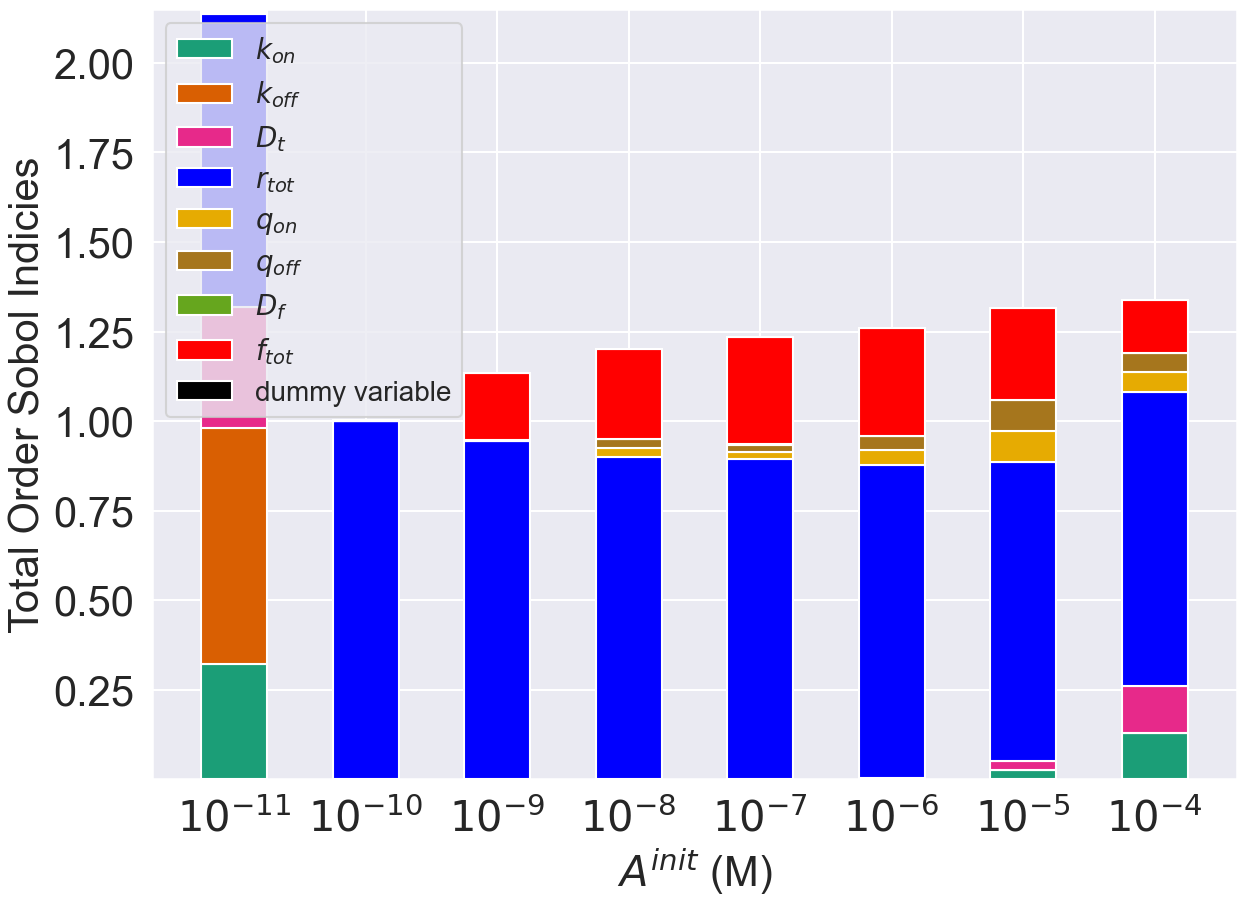

In [392]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_t_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
qon_si = np.zeros(len(A0s))
qoff_si = np.zeros(len(A0s))
D_f_si = np.zeros(len(A0s))
ftot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies[i]
    kon_si[i] = vals[0]
    koff_si[i] = vals[1]
    D_t_si[i] = vals[2]
    rtot_si[i] = vals[3]
    qon_si[i] = vals[4]
    qoff_si[i] = vals[5]
    D_f_si[i] = vals[6]
    ftot_si[i] = vals[7]
    dummy_si[i] = vals[8]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(14,10))
bottom = np.zeros(8)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k_{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k_{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, D_t_si, width, label=r'$D_t$', bottom= bottom, color=cm(3))
bottom+= D_t_si
ax.bar(ab_conc, rtot_si, width, label=r'$r_{tot}$', bottom= bottom, color='blue')
bottom+= rtot_si
ax.bar(ab_conc, qon_si, width, label=r'$q_{on}$', bottom= bottom, color=cm(5))
bottom+= qon_si
ax.bar(ab_conc, qoff_si, width, label=r'$q_{off}$', bottom= bottom, color=cm(6))
bottom+= qoff_si
ax.bar(ab_conc, D_f_si, width, label=r'$D_f$', bottom= bottom, color=cm(4))
bottom+= D_f_si
ax.bar(ab_conc, ftot_si, width, label=r'$f_{tot}$', bottom= bottom, color='red')
bottom+= ftot_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('Total Order Sobol Indicies', fontsize=30)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/synapse_approx_sa_no_div_ET20.png')